# 목차
- **STEP 1. 작업환경 구성하기**
- **STEP 2. 데이터셋 구성하기**
- **STEP 3. 생성자 모델 구현하기**
- **STEP 4. 판별자 모델 구현하기**
- **STEP 5. 손실함수와 최적화 함수 구현하기**
- **STEP 6. 훈련과정 상세 기능 구현하기**
- **STEP 7. 학습 과정 진행하기**
- STEP 8. (optional) GAN 훈련 과정 개선하기

In [1]:
# 주요 라이브러리 버전 확인
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  # 경고 메시지 무시

print(tf.__version__)
print(imageio.__version__)

2.6.0
2.9.0


## STEP 2. 데이터셋 구성하기
- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [2]:
# 데이터셋 구성하기
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape # 데이터셋 shape 확인

(50000, 32, 32, 3)

### 이미지 정규화 및 시각화

In [3]:
# 이미지의 max, min 픽셀 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# 정규화 (-1과 1사이의 값)
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


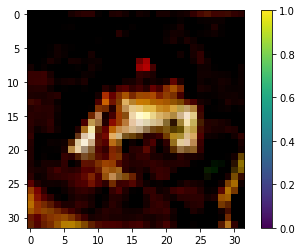

In [5]:
# index 0 이미지 시각화
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

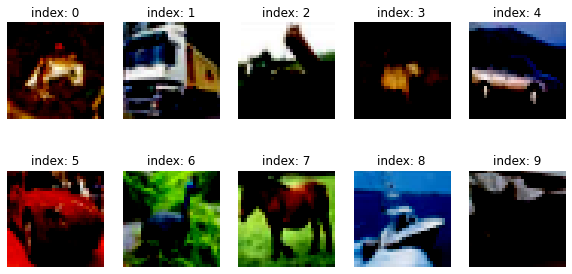

In [6]:
# 이미지 10개 시각화
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

### 미니배치 데이터셋 구성

In [7]:
BUFFER_SIZE = 50000 # 총 데이터 사이즈
BATCH_SIZE = 256 # 모델이 한 번에 학습할 데이터 사이즈

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 3. 생성자 모델 구현하기
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

### 생성자 모델 구현

In [8]:
def make_generator_model():
	
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    # units은 8x8x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,))) # CIFAR-10은 더 큰 이미지라서 8x8로 시작
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

### 랜덤 이미지 생성 및 출력 규격 확인

In [10]:
# 랜덤 노이즈 벡터 생성
noise = tf.random.normal([1, 100])

In [11]:
# 랜덤 노이즈 벡터를 생성자에 입력하여 가짜 이미지 생성
generated_image = generator(noise, training=False)
generated_image.shape # 생성된 이미지의 shape가 (32, 32, 3)인지 확인

TensorShape([1, 32, 32, 3])

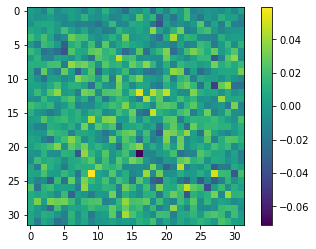

In [12]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현하기
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

### 판별자 모델 구현

In [13]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3])) # input_shape(32, 32, 3) 설정
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1)) # 판별결과 출력(1에 가까우면 진짜, 0에 가까우면 가짜라고 판별)

    return model

In [14]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

### STEP 2에서 생성한 랜덤 이미지 판별

In [15]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00277546]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현하기
- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

### 손실함수(loss) 구현

In [16]:
# 손실 함수 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
# 생성자의 손실 함수 (생성된 이미지를 진짜(1)로 판별하도록 유도)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
# 판별자의 손실 함수 (진짜는 1에, 가짜는 0에 가까워지도록 손실 계산)
def discriminator_loss(real_output, fake_output):
    
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 진짜 이미지에 대한 손실
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 가짜 이미지에 대한 손실
    
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    
    return total_loss

### 판별 정확도(accuracy) 계산 함수 구현

In [19]:
# 판별자의 정확도(accuracy) 계산 함수
def discriminator_accuracy(real_output, fake_output):
    
     # 판별자가 real_output을 0.5 이상으로 예측하면 True (정확)
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    
    # 판별자가 fake_output을 0.5 미만으로 예측하면 True (정확)
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    
    return real_accuracy, fake_accuracy

### optimizer 정의

In [20]:
# 생성자와 구분자 optimizer 각각 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
# 생성자 샘플 확인용 랜덤 노이즈 생성
noise_dim = 100 # 노이즈 차원 (100차원 벡터 사용)
num_examples_to_generate = 16 # 생성할 샘플 수

seed = tf.random.normal([num_examples_to_generate, noise_dim]) # 랜덤 노이즈 생성
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

### train_step() 함수 구현

In [22]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 훈련 과정 동안 생성한 이미지 시각화

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### draw_train_history() 함수 구현

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 # matlab 차트 크기를 15,6으로 지정

def draw_train_history(history, epoch):
    fig, axs = plt.subplots(2, 1)
    
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # tepoch별 그래프를 이미지 파일로 저장
    save_path = '{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'.format(os.getenv('HOME'), epoch)
    plt.savefig(save_path)
    plt.close(fig)

### checkpoint 모듈 설정

In [25]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기
- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

### 모델 학습 진행

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
save_every = 5
EPOCHS = 50

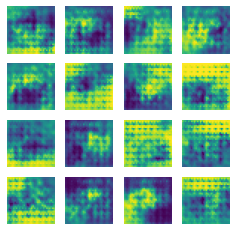

Time for training : 1280 sec
CPU times: user 21min 15s, sys: 1min 22s, total: 22min 37s
Wall time: 21min 20s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

### 학습 과정 시각화

In [31]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1272505 Mar 13 07:13 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


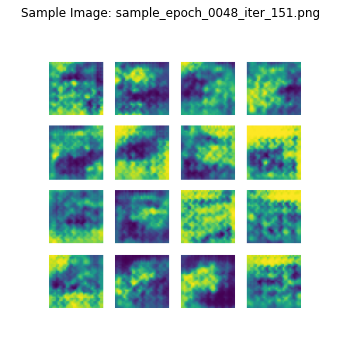

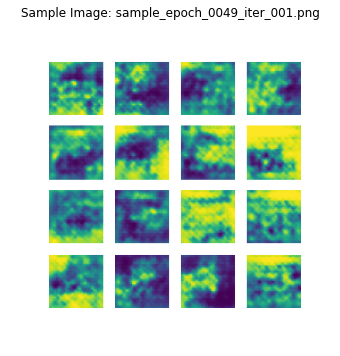

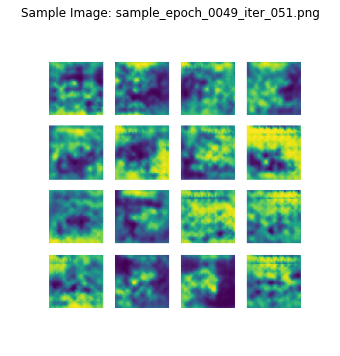

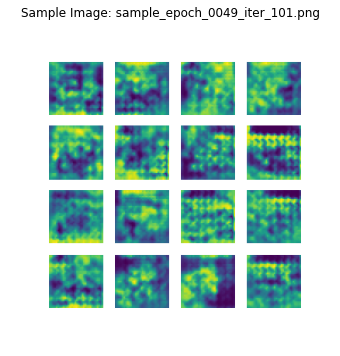

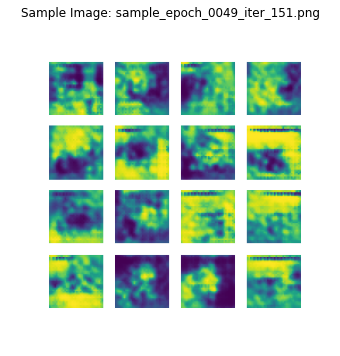

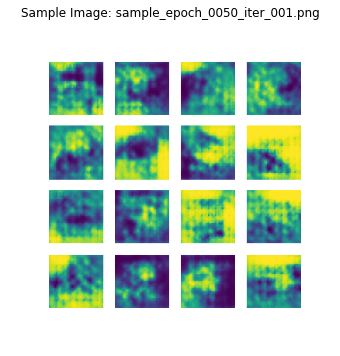

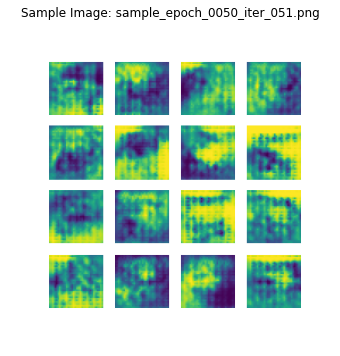

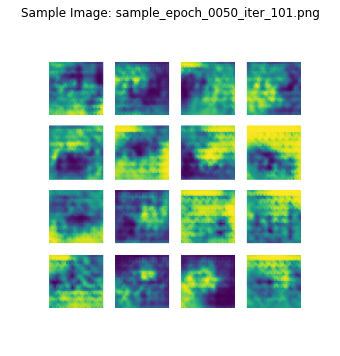

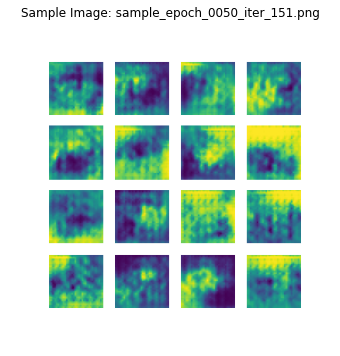

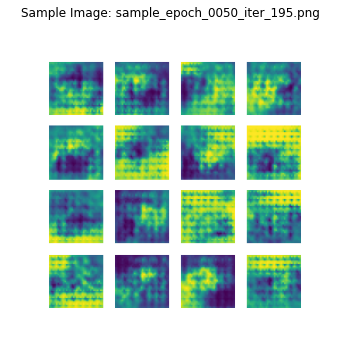

In [33]:
# 샘플 이미지 경로
sample_images = sorted(glob.glob(f'{os.getenv("HOME")}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_*.png'))

# 샘플 이미지 표시 (최근 10개)
for image_path in sample_images[-10:]:
    img = mpimg.imread(image_path)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Sample Image: {os.path.basename(image_path)}')
    plt.show()

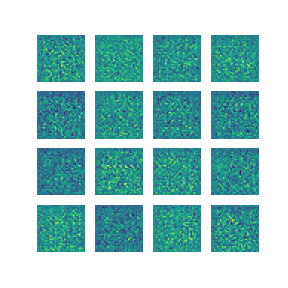

In [32]:
import matplotlib.image as mpimg
from IPython.display import Image, display

# GIF 파일 경로
gif_path = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

# GIF 파일 표시
display(Image(filename=gif_path))

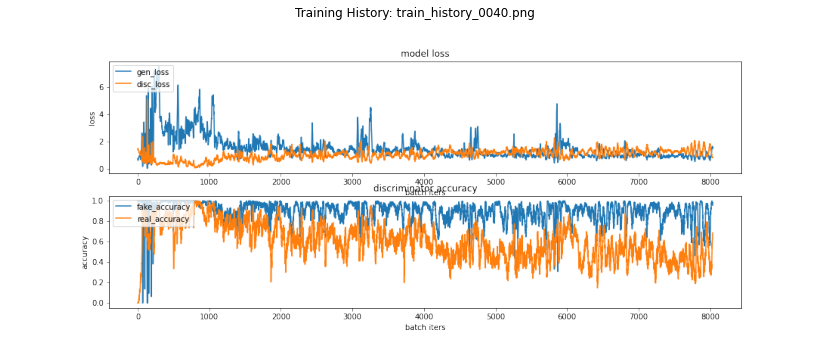

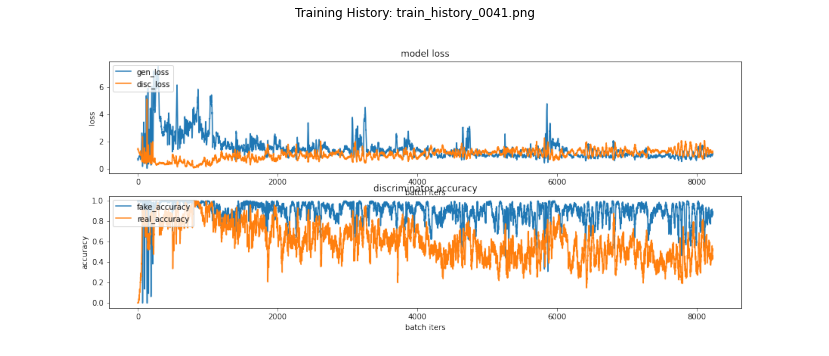

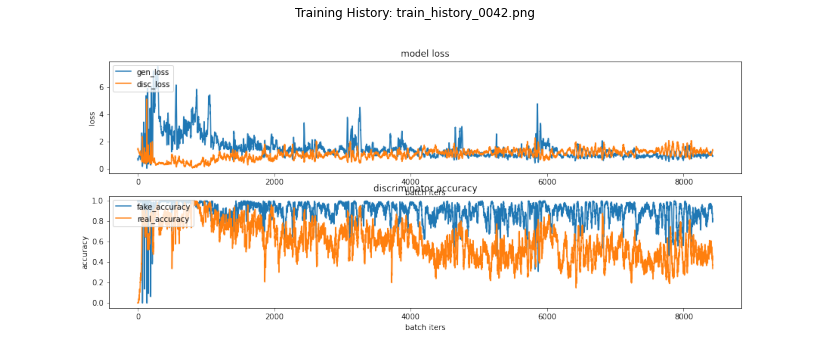

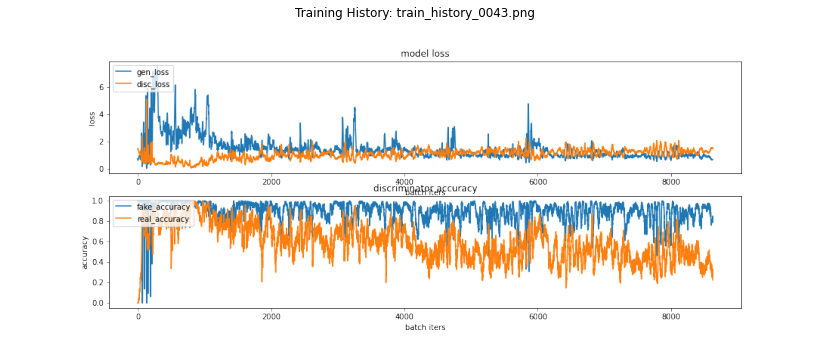

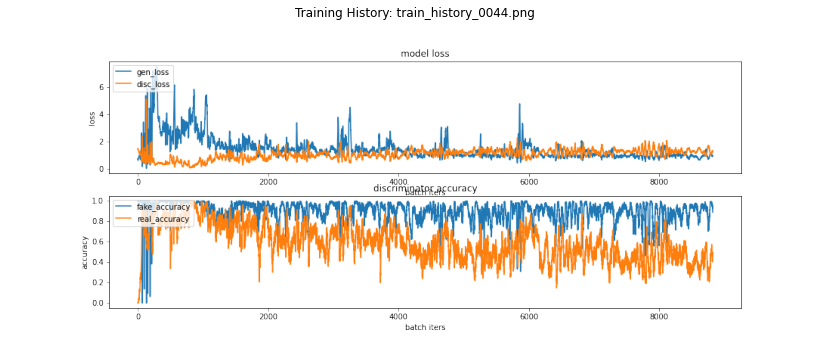

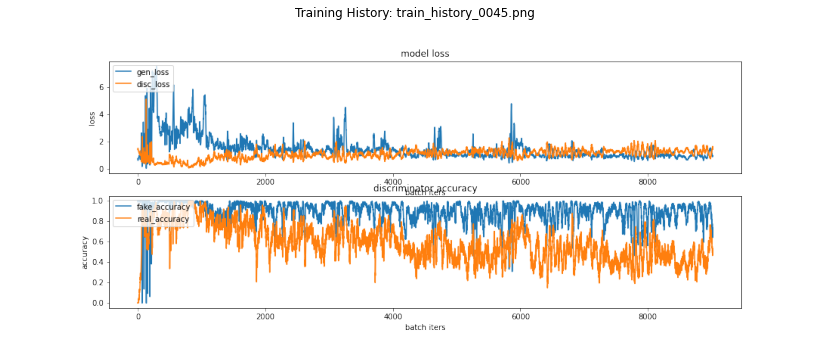

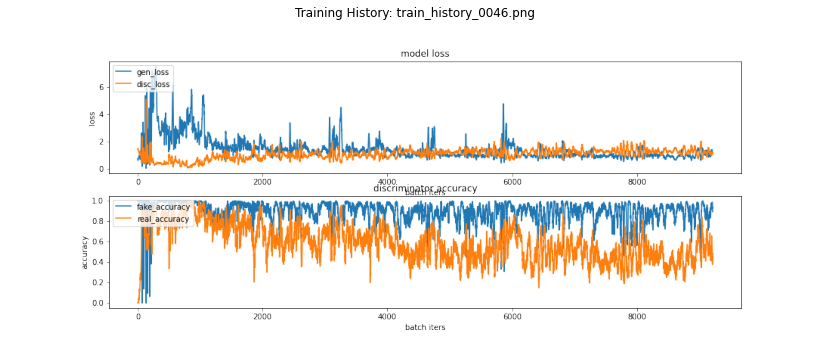

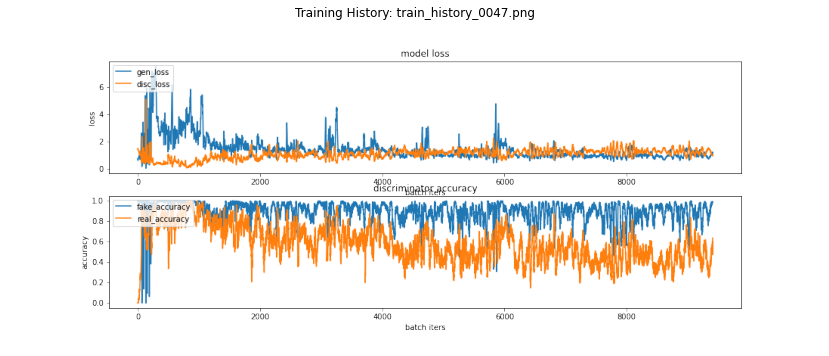

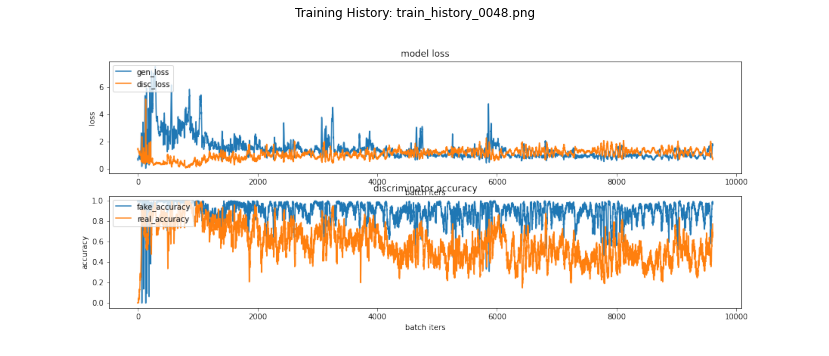

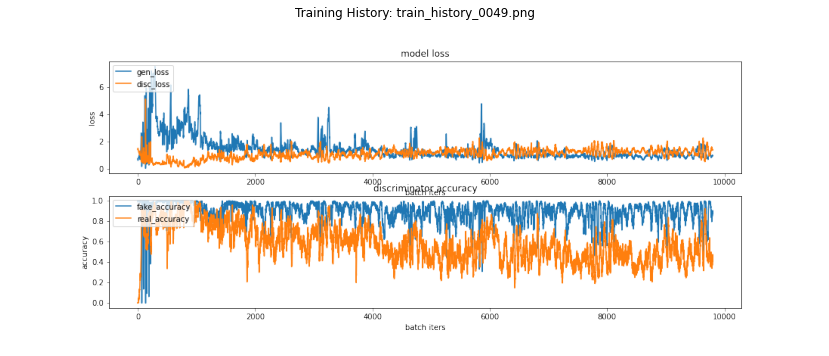

In [34]:
# 학습 진행 그래프 경로
graph_images = sorted(glob.glob(f'{os.getenv("HOME")}/aiffel/dcgan_newimage/cifar10/training_history/train_history_*.png'))

# 학습 그래프 표시 (최근 10개)
for graph_path in graph_images[-10:]:
    img = mpimg.imread(graph_path)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Training History: {os.path.basename(graph_path)}')
    plt.show()

Training history GIF saved at: /aiffel/aiffel/dcgan_newimage/cifar10/training_history.gif


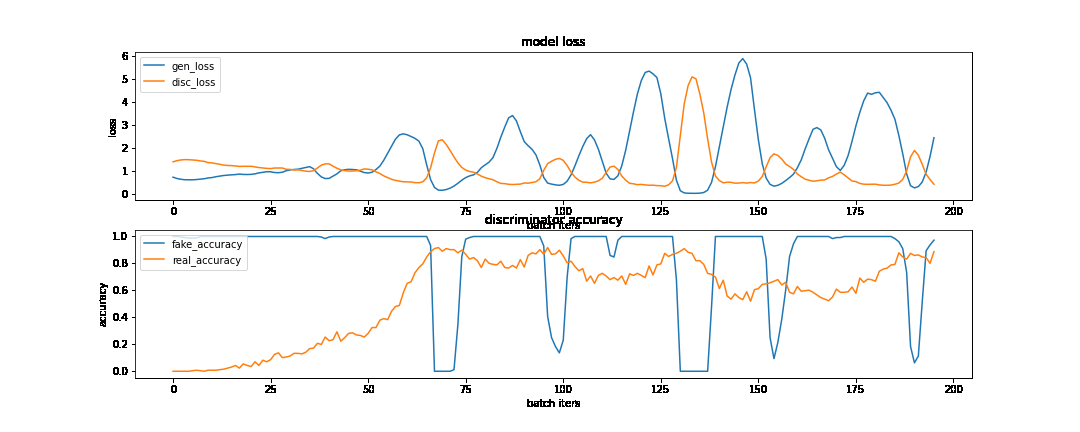

In [37]:
# 저장할 GIF 파일 경로
graph_gif_path = os.path.join(os.getenv('HOME'), 'aiffel/dcgan_newimage/cifar10/training_history.gif')

# 학습 그래프 이미지 경로 가져오기
graph_images = sorted(glob.glob(f'{os.getenv("HOME")}/aiffel/dcgan_newimage/cifar10/training_history/train_history_*.png'))

# GIF 파일로 저장
with imageio.get_writer(graph_gif_path, mode='I', duration=0.1) as writer:
    for filename in graph_images:
        image = imageio.imread(filename)  # v2 제거
        writer.append_data(image)

print(f"Training history GIF saved at: {graph_gif_path}")

# 저장한 GIF 파일 표시
display(Image(filename=graph_gif_path))

### [ 문제점 분석 ]

**1. 손실 그래프 (model loss)**
1) gen_loss (생성자 손실):
- 초반에 급격하게 감소한 후 진동하며 불안정한 패턴을 보임
- 중반 이후에는 낮은 값으로 수렴하고 있지만, 여전히 진동성이 강함

2) disc_loss (판별자 손실):
- 초반에는 생성자보다 낮은 손실을 보이다가, 중반 이후 비교적 안정적으로 수렴함
- 하지만, gen_loss가 너무 낮아지면 판별자의 학습이 어려워지는 현상이 발생할 수 있음

**2. 판별자 정확도 그래프 (discriminator accuracy)**
1) fake_accuracy (가짜 이미지를 가짜라고 판별한 비율):
- 중반 이후 거의 1에 가까운 정확도를 보임
- 즉, 판별자는 가짜 이미지를 너무 쉽게 판별하고 있다는 뜻

2) real_accuracy (진짜 이미지를 진짜라고 판별한 비율):
- 초기에는 1에 가까웠지만, 시간이 지남에 따라 불안정하게 진동하고 있음
- 판별자가 진짜 이미지도 제대로 판별하지 못하는 시점이 존재함

**3. 샘플 이미지 분석**
- 생성된 이미지들이 형체를 알아볼 수 없는 수준임
- 색상과 픽셀은 랜덤 노이즈처럼 보이며, 특징적인 형태가 전혀 보이지 않음
- 이는 판별자가 너무 강해져서 생성자가 학습을 제대로 하지 못하는 현상일 수 있음

### [ 문제점 정리 ]

**1. 판별자가 너무 강함**
- fake_accuracy가 1에 가까워지면서 생성자는 거의 속이지 못하고 있음
- 생성자는 반복적으로 패배하면서 제대로 학습을 하지 못하고 있음

**2. 생성자 학습 불안정**
- gen_loss가 진동성이 강하고, 제대로 수렴하지 못함
- 샘플 이미지에서 볼 수 있듯, 생성자는 의미 있는 이미지를 전혀 생성하지 못하고 있음